### __Project Title:__ GridCast  
__Dataset:__ [EIA API](https://www.eia.gov/opendata/)  
__Dataset URL:__ https://www.eia.gov/opendata/  
__Why this dataset:__  The EIA Open Data API provides real-time and historical electricity information from U.S. grid operators, including demand, generation mix, and retail sales. The data updates across multiple regions, allowing us to analyze how geography and time-of-day may affect energy usage. This dataset works well for our project because it supports strong map based visualizations that could inform data center siting decisions.  

__Brief writeup of what you intend to do (5-10 lines):__  

Our project's goal is to create a map of electricity data pulled from the EIA API, and potentially other future datasets to help data center planners or companies. The final dynamic graph would look something like a map of the United States with a grid overlayed to show the best "cells" where a combination of characteristics like energy price, renewable energy availability, and temperature would make for the best location of a future data center that is both sustainable and profitable at the same time. We will visualize this with an eventual _datacenter score_ that maps every cell in the grid with a score and the higher the score the darker the cell will appear. This map/dashboard will be accompanied by a webpage that explains the importance of sustainability and the increasing need of making data centers more sustainable considering the rise of the usage of AI.

In [4]:
import os
import requests
import pandas as pd
import plotly.express as px
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
AGGREGATED_REGIONS = [
    "CAL",
    "CAR",
    "CENT",
    "FLA",
    "MIDA",
    "MIDW",
    "NE",
    "NW",
    "NY",
    "SE",
    "SW",
    "TEN",
    "TEX",
    "US48",
]

EIA_API_KEY = "LV5kvcaKFEC82n5eKGYAhRg6d3Tq3Mjx9FznbVXg"
if not EIA_API_KEY:
    raise EnvironmentError("Please set your EIA_API_KEY environment variable.")

url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"
params = {
    "api_key": EIA_API_KEY,
    "frequency": "hourly",
    "data[0]": "value",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
    "facets[type][]": "D"  # <--- Adds filter for only 'Demand' (Actual)
                           # Use "DF" if you specifically want the Forecast
}
params["facets[respondent][]"] = AGGREGATED_REGIONS

try:
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()["response"]["data"]
    df = pd.DataFrame(data)
    df.to_csv("eia_hourly_cached.csv", index=False)
except Exception as exc:
    cache_path = "eia_hourly_cached.csv"
    if not os.path.exists(cache_path):
        raise RuntimeError("Failed to download data and no cached file was found.") from exc
    print(f"⚠️ Using cached data because API request failed: {exc}")
    df = pd.read_csv(cache_path)

df["region"] = df["respondent"]
df.head()

,period,respondent,respondent-name,type,type-name,value,value-units,region
0,2025-11-26T00,CAL,California,D,Demand,29166,megawatthours,CAL
1,2025-11-26T00,CAR,Carolinas,D,Demand,22398,megawatthours,CAR
2,2025-11-26T00,CENT,Central,D,Demand,33722,megawatthours,CENT
3,2025-11-26T00,FLA,Florida,D,Demand,33625,megawatthours,FLA
4,2025-11-26T00,MIDA,Mid-Atlantic,D,Demand,96684,megawatthours,MIDA


In [7]:
df = df.copy()
df["region"] = df["respondent"]
df["datetime"] = pd.to_datetime(df["period"])
df["demand_MW"] = pd.to_numeric(df["value"], errors="coerce")

latest_idx = df.groupby("region")["datetime"].idxmax()
latest_df = df.loc[latest_idx].copy()
usage = latest_df[["region", "demand_MW", "datetime"]]
latest_time = usage["datetime"].max() # <--Grab the latest data

In [8]:
# ======================================================
# 2️⃣ Region → state mapping (unchanged)
# ======================================================
region_to_states = {
    "CAL": ["California"],
    "CAR": ["North Carolina", "South Carolina"],
    "CENT": ["Arkansas", "Kansas", "Louisiana", "Missouri", "Nebraska", "Oklahoma"],
    "FLA": ["Florida"],
    "MIDA": ["Delaware", "District of Columbia", "Maryland", "New Jersey", "Pennsylvania", "Virginia", "West Virginia"],
    "MIDW": ["Illinois", "Indiana", "Iowa", "Kentucky", "Michigan", "Minnesota", "North Dakota", "Ohio", "South Dakota", "Wisconsin"],
    "NE": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
    "NY": ["New York"],
    "NW": ["Idaho", "Montana", "Oregon", "Washington", "Wyoming"],
    "SE": ["Alabama", "Georgia", "Mississippi"],
    "SW": ["Arizona", "Colorado", "New Mexico", "Nevada", "Utah"],
    "TEN": ["Tennessee"],
    "TEX": ["Texas"],
}

usage = usage[usage["region"].isin(region_to_states)].copy()
usage["state_list"] = usage["region"].map(region_to_states)
usage = usage.explode("state_list").rename(columns={"state_list": "state"})

In [9]:
usage

,region,demand_MW,datetime,state
0,CAL,29166,2025-11-26,California
1,CAR,22398,2025-11-26,North Carolina
1,CAR,22398,2025-11-26,South Carolina
2,CENT,33722,2025-11-26,Arkansas
2,CENT,33722,2025-11-26,Kansas
2,CENT,33722,2025-11-26,Louisiana
2,CENT,33722,2025-11-26,Missouri
2,CENT,33722,2025-11-26,Nebraska
2,CENT,33722,2025-11-26,Oklahoma
3,FLA,33625,2025-11-26,Florida


In [10]:
# ======================================================
# 3️⃣ Choropleth via Folium (OpenStreetMap)
# ======================================================
geo_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"

m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="CartoDB positron")

choropleth = folium.Choropleth(
    geo_data=geo_url,
    name="Electricity Demand (MW)",
    data=usage,
    columns=["state", "demand_MW"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="gray",
    legend_name=f"Electricity Demand (MW) — {latest_time:%Y-%m-%d %H:%M}",
).add_to(m)

# ✅ tooltip must attach to a GeoJson object, not the map
folium.GeoJson(
    geo_url,
    name="State Boundaries",
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],
        aliases=["State:"],
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)

m

In [11]:
# --- Data Prep ---
# Ensure datetime is correct
df['datetime'] = pd.to_datetime(df['period'])
df['hour'] = df['datetime'].dt.hour
df['demand_MW'] = pd.to_numeric(df['value'], errors='coerce')

sns.set_theme(style="whitegrid")

df_no48 = df[df['respondent'] != 'US48']

In [12]:
df[df['respondent'] == 'US48']

,period,respondent,respondent-name,type,type-name,value,value-units,region,datetime,demand_MW,hour
13,2025-11-26T00,US48,United States Lower 48,D,Demand,484423,megawatthours,US48,2025-11-26 00:00:00,484423,0
27,2025-11-25T23,US48,United States Lower 48,D,Demand,495095,megawatthours,US48,2025-11-25 23:00:00,495095,23
41,2025-11-25T22,US48,United States Lower 48,D,Demand,491020,megawatthours,US48,2025-11-25 22:00:00,491020,22
55,2025-11-25T21,US48,United States Lower 48,D,Demand,488997,megawatthours,US48,2025-11-25 21:00:00,488997,21
69,2025-11-25T20,US48,United States Lower 48,D,Demand,488332,megawatthours,US48,2025-11-25 20:00:00,488332,20
...,...,...,...,...,...,...,...,...,...,...,...
4941,2025-11-11T08,US48,United States Lower 48,D,Demand,456475,megawatthours,US48,2025-11-11 08:00:00,456475,8
4955,2025-11-11T07,US48,United States Lower 48,D,Demand,462754,megawatthours,US48,2025-11-11 07:00:00,462754,7
4969,2025-11-11T06,US48,United States Lower 48,D,Demand,471502,megawatthours,US48,2025-11-11 06:00:00,471502,6
4983,2025-11-11T05,US48,United States Lower 48,D,Demand,483391,megawatthours,US48,2025-11-11 05:00:00,483391,5


## 5-6 static visualizations on your dataset

#### Visualization 1: The "Daily Cycle" Line Chart (Last 48 Hours)

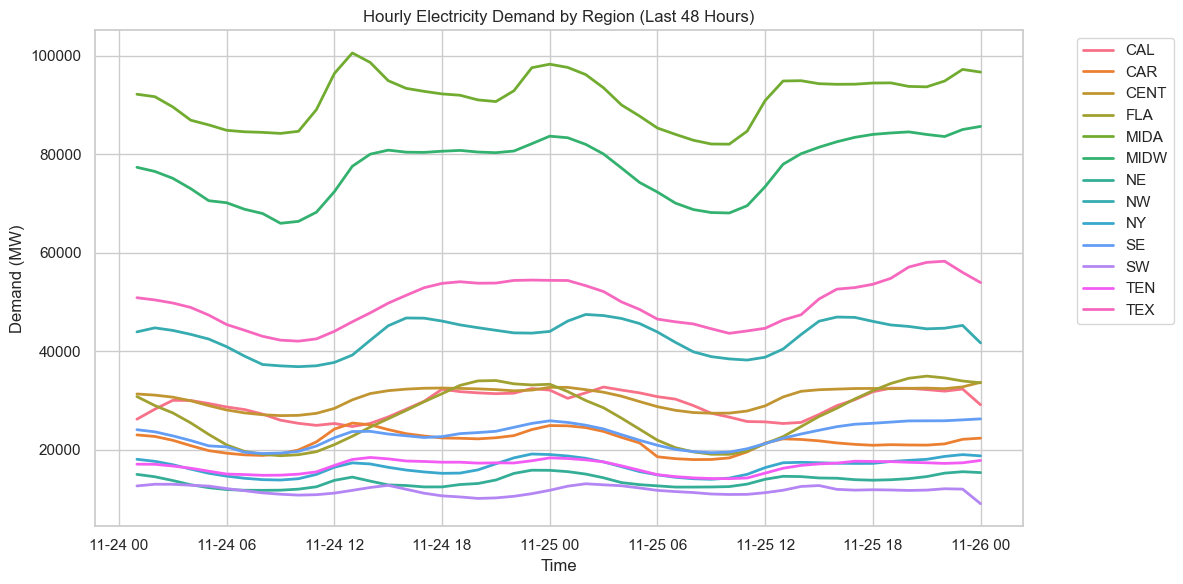

In [13]:
plt.figure(figsize=(12, 6))
# Filter for last 48 hours to make the line chart readable
recent_cutoff = df_no48['datetime'].max() - pd.Timedelta(hours=48)
subset = df_no48[df_no48['datetime'] > recent_cutoff]

sns.lineplot(data=subset, x='datetime', y='demand_MW', hue='region', linewidth=2)
plt.title("Hourly Electricity Demand by Region (Last 48 Hours)")
plt.ylabel("Demand (MW)")
plt.xlabel("Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Visualization 2: The "Volatility" Box Plot

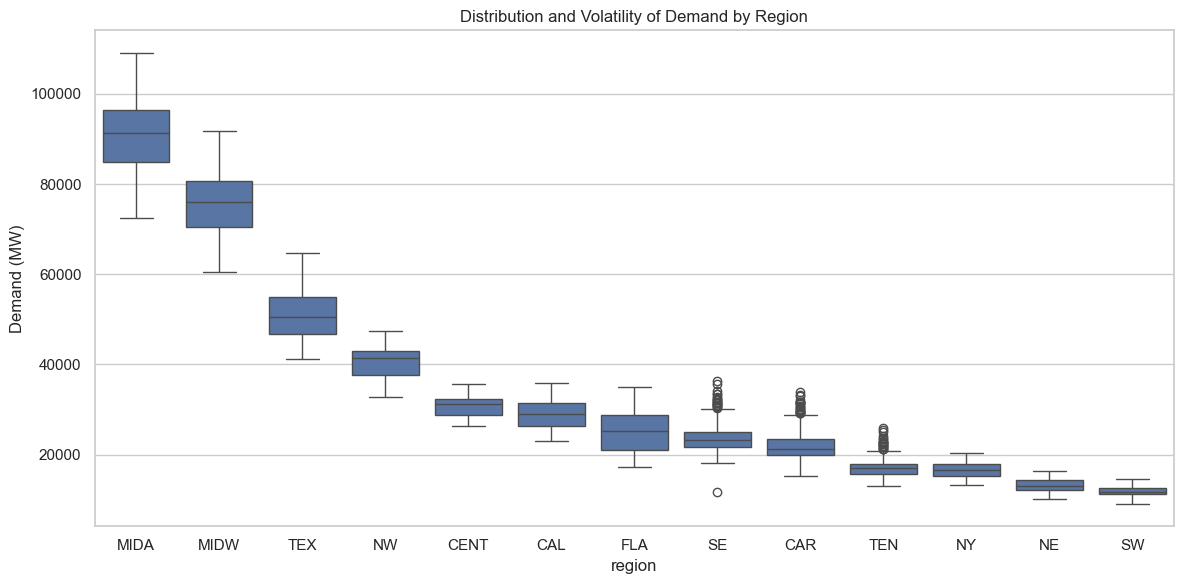

In [14]:
plt.figure(figsize=(12, 6))
# Sort by median demand for cleaner look
sorted_regions = df_no48.groupby('region')['demand_MW'].median().sort_values(ascending=False).index

sns.boxplot(data=df_no48, x='region', y='demand_MW', order=sorted_regions)
plt.title("Distribution and Volatility of Demand by Region")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.show()

### Visualization 3: The "Habit" Heatmap

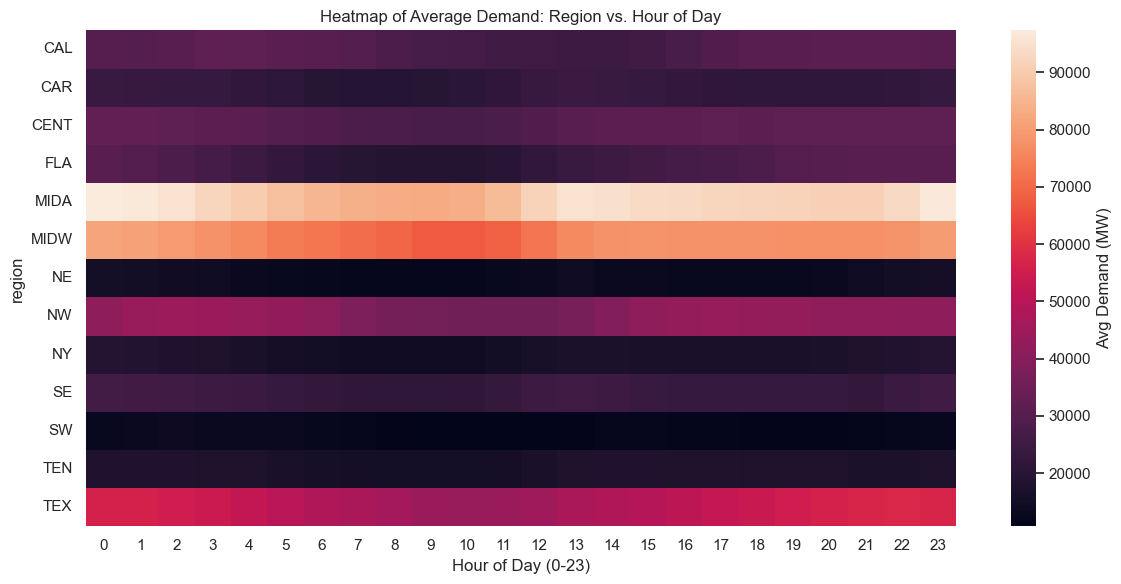

In [15]:
# Pivot data to get Region vs Hour matrix
heatmap_data = df_no48.groupby(['region', 'hour'])['demand_MW'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='region', columns='hour', values='demand_MW')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cbar_kws={'label': 'Avg Demand (MW)'})
plt.title("Heatmap of Average Demand: Region vs. Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.tight_layout()
plt.show()

### Visualization 4: The "Regional Share" Bar Chart

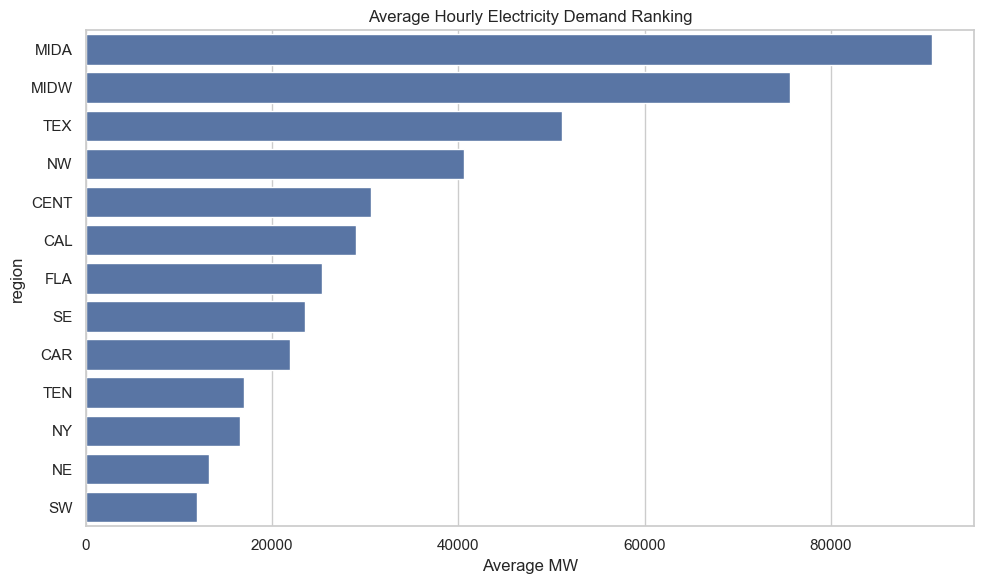

In [16]:
plt.figure(figsize=(10, 6))
avg_demand = df_no48.groupby('region')['demand_MW'].mean().sort_values(ascending=False).reset_index()

sns.barplot(data=avg_demand, y='region', x='demand_MW')
plt.title("Average Hourly Electricity Demand Ranking")
plt.xlabel("Average MW")
plt.tight_layout()
plt.show()

### Visualization 5: The "Total Load" Stacked Area Chart

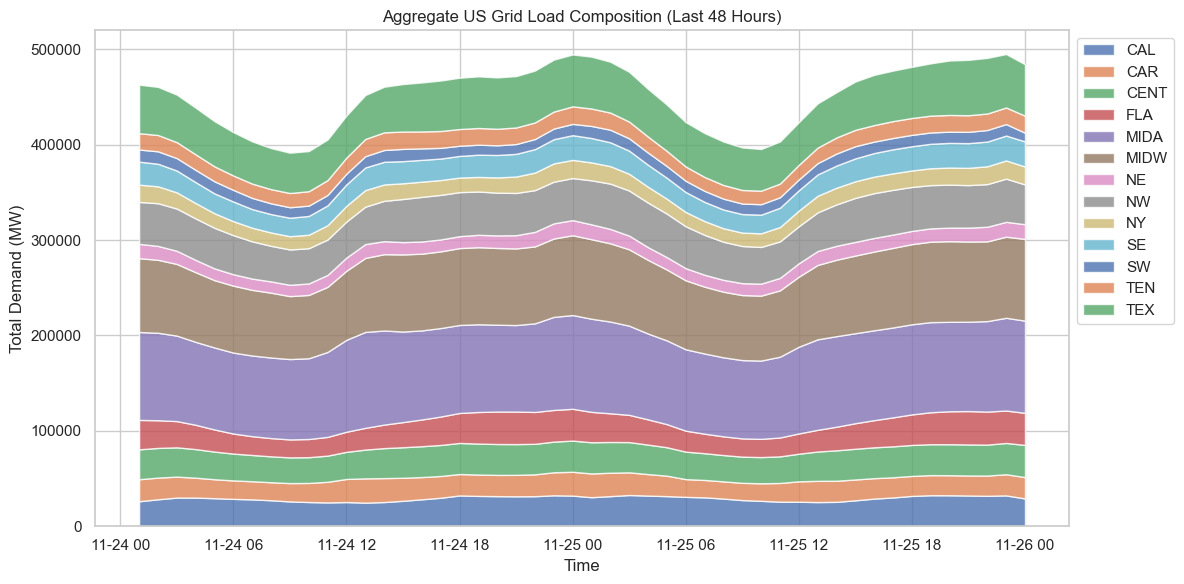

In [17]:
# Pivot for stacking
pivot_df = subset.pivot(index='datetime', columns='region', values='demand_MW').fillna(0)

plt.figure(figsize=(12, 6))
plt.stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.8)
plt.title("Aggregate US Grid Load Composition (Last 48 Hours)")
plt.ylabel("Total Demand (MW)")
plt.xlabel("Time")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd

# -------------------------------------------------------------
# 1. Load your EIA regional hourly data
# -------------------------------------------------------------
eia = pd.read_csv("eia_hourly_cached.csv")

# -------------------------------------------------------------
# 2. Choose ONE hour for your prototype (you can change this)
# -------------------------------------------------------------
hour = "2025-11-19T06"
snap = eia[eia["period"] == hour].copy()

# Remove the US48 total row (not needed for map)
snap = snap[snap["respondent"] != "US48"]

# -------------------------------------------------------------
# 3. Normalize demand (for map color)
# -------------------------------------------------------------
vals = snap["value"]
snap["score_demand"] = (vals - vals.min()) / (vals.max() - vals.min())

# -------------------------------------------------------------
# 4. Region-to-states mapping
#    (copy/paste exactly what you provided)
# -------------------------------------------------------------
region_to_states = {
    "CAL": ["California"],
    "CAR": ["North Carolina", "South Carolina"],
    "CENT": ["Arkansas", "Kansas", "Louisiana", "Missouri", "Nebraska", "Oklahoma"],
    "FLA": ["Florida"],
    "MIDA": ["Delaware", "District of Columbia", "Maryland", "New Jersey", "Pennsylvania", "Virginia", "West Virginia"],
    "MIDW": ["Illinois", "Indiana", "Iowa", "Kentucky", "Michigan", "Minnesota", "North Dakota", "Ohio", "South Dakota", "Wisconsin"],
    "NE": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
    "NY": ["New York"],
    "NW": ["Idaho", "Montana", "Oregon", "Washington", "Wyoming"],
    "SE": ["Alabama", "Georgia", "Mississippi"],
    "SW": ["Arizona", "Colorado", "New Mexico", "Nevada", "Utah"],
    "TEN": ["Tennessee"],
    "TEX": ["Texas"],
}

# -------------------------------------------------------------
# 5. Build per-state rows containing BOTH raw and normalized data
# -------------------------------------------------------------
rows = []

for _, row in snap.iterrows():
    region = row["respondent"]
    demand_raw = row["value"]            # raw MWh
    score_demand = row["score_demand"]   # normalized (0–1)

    if region not in region_to_states:
        # If region not in mapping, skip it
        continue

    for state in region_to_states[region]:
        rows.append({
            "state": state,
            "demand_raw": demand_raw,         # For tooltips
            "score_demand": score_demand,     # For color scale
            "score_combo": score_demand,      # Placeholder = same as score_demand
            "score_renewables": 0.5,          # Placeholder
        })

# -------------------------------------------------------------
# 6. Save final CSV
# -------------------------------------------------------------
state_metrics = pd.DataFrame(rows)
state_metrics.to_csv("data/state_metrics.csv", index=False)

state_metrics.head()


,state,demand_raw,score_demand,score_combo,score_renewables
0,California,31006,0.257154,0.257154,0.5
1,North Carolina,20567,0.117703,0.117703,0.5
2,South Carolina,20567,0.117703,0.117703,0.5
3,Arkansas,28832,0.228112,0.228112,0.5
4,Kansas,28832,0.228112,0.228112,0.5
